----
<h1><center><b>Image Captioning Project</b></center></h1>

----

### importing neccessary libraries

In [24]:
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
import re
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

## Dataset
- The Flickr30K dataset image captioning project. It consists of more than 30,000 images, each paired with five human-written captions describing the scene. 
- 

### getting captions from result.csv

In [25]:
captions = pd.read_csv(f'flickr30k_images/results.csv', delimiter='|')
captions.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [26]:
captions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   image_name       158915 non-null  object
 1    comment_number  158915 non-null  object
 2    comment         158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [27]:
captions.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [28]:
captions.columns = captions.columns.str.strip()
captions.columns

Index(['image_name', 'comment_number', 'comment'], dtype='object')

In [29]:
type(captions)

pandas.core.frame.DataFrame

### handling null values in comment column

In [30]:
captions.isna().sum()

image_name        0
comment_number    0
comment           1
dtype: int64

In [31]:
captions['comment'] = captions['comment'].fillna(" ")
captions.isna().sum()

image_name        0
comment_number    0
comment           0
dtype: int64

### getting view on images and their's caption

In [32]:
from PIL import Image
from textwrap import wrap

def readImage(path, img_size=256):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    img = Image.open(path).convert('RGB')
    img = transform(img)
    return img.permute(1, 2, 0).numpy()

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        image_path = f"flickr30k_images/flickr30k_images/{temp_df.image_name[i]}"
        image = readImage(image_path)
        plt.imshow(image)

        caption = "\n".join(wrap(temp_df.comment[i], 20))
        plt.title(caption)
        plt.axis("off")

    plt.show()

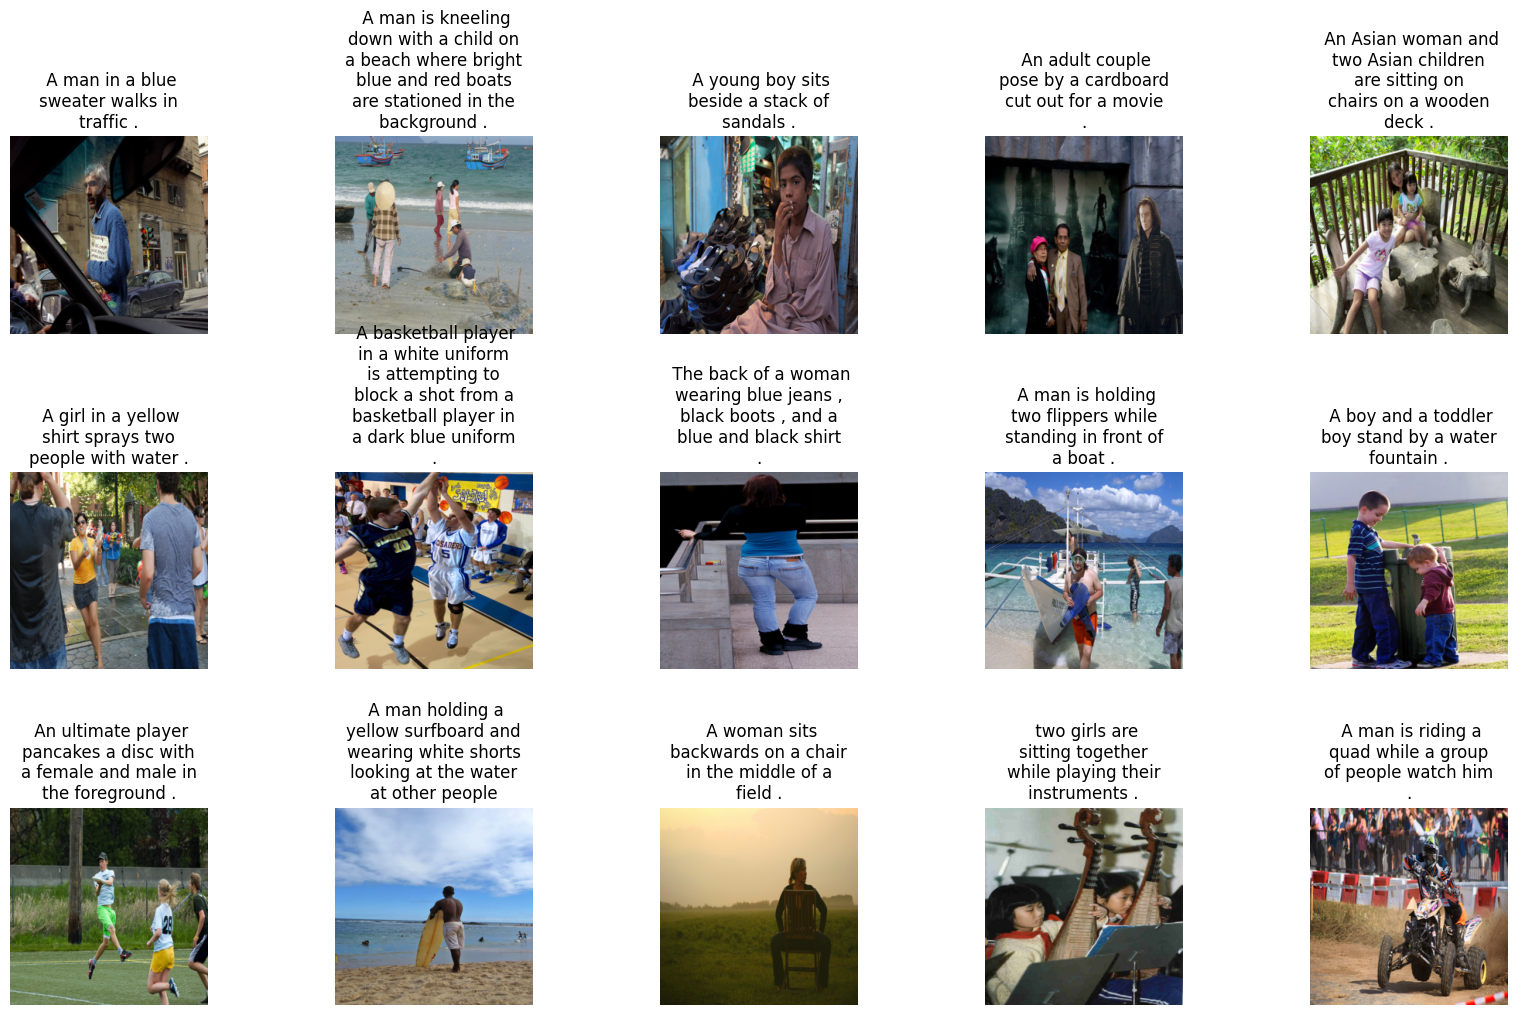

In [33]:
display_images(captions.sample(15))

In [34]:
image_captions = defaultdict(list)
for idx, row in captions.iterrows():
    image_captions[row['image_name']].append(row['comment'])

def tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\w+', text)
    return tokens

all_captions = []
for captions in image_captions.values():
    all_captions.extend(captions)

all_words = []
for caption in all_captions:
    tokens = tokenize(caption)
    all_words.extend(tokens)

word_counts = Counter(all_words)

special_tokens = ['<pad>', '<start>', '<end>', '<unk>']
word2idx = {token: idx for idx, token in enumerate(special_tokens)}
idx2word = {idx: token for idx, token in enumerate(special_tokens)}

vocab_size = 10000
most_common = word_counts.most_common(vocab_size - len(special_tokens))

for idx, (word, _) in enumerate(most_common, start=len(special_tokens)):
    word2idx[word] = idx
    idx2word[idx] = word

captions_seqs = {}
max_length = 0
for img_name, captions in image_captions.items():
    seqs = []
    for caption in captions:
        tokens = ['<start>'] + tokenize(caption) + ['<end>']
        seq = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
        seqs.append(seq)
        max_length = max(max_length, len(seq))
    captions_seqs[img_name] = seqs

In [35]:
path = 'flickr30k_images/flickr30k_images'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, 3, -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4441, 0.4211, 0.3847])
Std: tensor([0.2416, 0.2311, 0.2328])


In [36]:
transform = transforms.Compose(
      [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.444, 0.421, 0.386), (0.242, 0.231, 0.233)),
      ]
  )

In [37]:
class Flickr30kDataset(Dataset):
    def __init__(self, image_dir, image_ids, captions_seqs, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.captions = []

        for img_id in image_ids:
            captions = captions_seqs[img_id]
            for caption_seq in captions:
                self.images.append(img_id)
                self.captions.append(caption_seq)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = self.images[idx]
        caption_seq = self.captions[idx]
        img_path = os.path.join(self.image_dir, img_id)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption_seq = torch.tensor(caption_seq)
        return image, caption_seq

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths

In [38]:
from sklearn.model_selection import train_test_split

image_dir = f'{path}/flickr30k_images'

image_names = list(image_captions.keys())
train_images, val_test_images = train_test_split(image_names, test_size=0.1, random_state=42)
val_images, test_images = train_test_split(val_test_images, test_size=0.5, random_state=42)

train_dataset = Flickr30kDataset(image_dir, train_images, captions_seqs, transform)
val_dataset   = Flickr30kDataset(image_dir, val_images, captions_seqs, transform)
test_dataset  = Flickr30kDataset(image_dir, test_images, captions_seqs, transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [39]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(256 * 8 * 8, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, images):
        x = self.pool(F.relu(self.conv1(images)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

In [40]:
class Decoder(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        lstm_out, _ = self.lstm(embeddings)
        outputs = self.fc(lstm_out)
        return outputs

In [41]:
class CNN_RNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNN_RNN, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result = []
        with torch.no_grad():
            image = image.unsqueeze(0)
            x = self.encoder(image)
            states = (torch.zeros(self.decoder.lstm.num_layers, 1, self.decoder.lstm.hidden_size).to(image.device),
                      torch.zeros(self.decoder.lstm.num_layers, 1, self.decoder.lstm.hidden_size).to(image.device))

            for _ in range(max_length):
                x, states = self.decoder.lstm(x, states)
                output = self.decoder.fc(x.squeeze(1))
                predicted = output.argmax(dim=1)

                word = vocabulary.itos[predicted.item()]
                result.append(word)

                if word == "<end>":
                    break

                x = self.decoder.embed(predicted)

        return result

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [43]:
num_epochs = 30
embed_size = 256
hidden_size = 512
vocab_size = len(word2idx)
num_layers = 2
learning_rate = 0.001

model = CNN_RNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

In [44]:
train_losses = []
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_train_loss = 0
        print(f'epoch: {epoch}')
        for images, captions, _ in train_loader:
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            targets = captions[:, 1:]
            outputs = outputs[:, :targets.shape[1], :]
            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5) 
            optimizer.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    

In [ ]:
train_model(model, train_loader, criterion, optimizer, num_epochs)

epoch: 0


In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()